## Image Saliency

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
from skimage import util
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import math
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

(345, 518, 3)


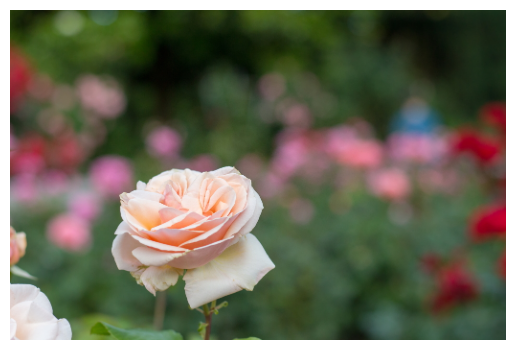

In [162]:
file_path = "/content/flower.jpg"
img = cv2.imread(file_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

imgHeight = img.shape[0]
imgWidth = img.shape[1]
scale = 0.5

img = cv2.resize(img, (int(imgWidth * scale), int(imgHeight * scale)))
cv2.imwrite("/content/img.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
print(img.shape)

plt.imshow(img)
plt.axis('off')
plt.show()

In [163]:
def Saliency(img, patchSize, varThresh, scale):

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray_img = img_as_float(gray_img)

  img = img_as_float(img)

  segments = slic(img, n_segments = 100, sigma = 0, start_label = 0)
  numSegments = segments.max() + 1

  segmentValues = []
  for i in range(numSegments):
    segmentValues.append([])

  segmentColors = np.zeros((numSegments, 3))

  patternSaliency = np.zeros((imgHeight, imgWidth))
  colorSaliency = np.zeros((imgHeight, imgWidth))

  # Pattern saliency
  for x in range(imgHeight):
    for y in range(imgWidth):
      segmentLabel = segments[x][y]
      segmentValues[segmentLabel].append(img[x][y])

  segmentVariances = []
  for i in range(numSegments):
    segment = np.array(segmentValues[i])

    rChannel = segment[:, 0]
    gChannel = segment[:, 1]
    bChannel = segment[:, 2]

    rVar = np.var(rChannel)
    gVar = np.var(gChannel)
    bVar = np.var(bChannel)

    segmentVar = rVar + gVar + bVar
    segmentVariances.append([segmentVar, i])

  segmentVariances.sort(reverse = True)
  numTopSegments = int(numSegments * varThresh)

  topSegments = []
  for i in range(numTopSegments):
    topSegments.append(segmentVariances[i][1])
  topSegments.sort()

  avgPatch = {"coord" : np.array([0, 0]), "data" : np.zeros((patchSize, patchSize, 3))} # color img
  # avgPatch = {"coord" : np.array([0, 0]), "data" : np.zeros((patchSize, patchSize))} # gray img
  patches = []
  topPatches = []

  rowOffset = patchSize - 1
  colOffset = patchSize - 1

  avgTopSegmentPos = np.array([0, 0])

  for x in range(0, imgHeight, patchSize):
    for y in range(0, imgWidth, patchSize):
      rightBound = y + rowOffset
      bottomBound = x + colOffset
      segmentLabel = segments[x][y]

      if(rightBound < imgWidth and bottomBound < imgHeight):
        patch = img[x : x + patchSize, y : y + patchSize, :] # color img
        # patch = gray_img[x : x + patchSize, y : y + patchSize] # gray img
        patches.append({"coord" : np.array([x, y]), "data" : patch, "dist" : 0})

        avgPatch["coord"] = avgPatch["coord"] + np.array([x, y])
        avgPatch["data"] = avgPatch["data"] + patch

        if(segmentLabel in topSegments and segments[x][y + colOffset] in topSegments and segments[x + rowOffset][y] in topSegments and segments[x + rowOffset][y + colOffset] in topSegments):
          topPatches.append({"coord" : np.array([x, y]), "data" : patch})

          # avgPatch["coord"] = avgPatch["coord"] + np.array([x, y])
          # avgPatch["data"] = avgPatch["data"] + patch

  for patch in topPatches:
    avgTopSegmentPos = avgTopSegmentPos + patch["coord"]

  avgTopSegmentPos = avgTopSegmentPos / len(topPatches)

  avgPatch["coord"] = avgPatch["coord"] / len(patches)
  avgPatch["data"] = avgPatch["data"] / len(patches)

  # print(avgPatch["coord"])
  # print(avgPatch["data"])

  avgCoord = avgPatch["coord"]
  avgData = avgPatch["data"]

  # PCA calculation
  pca_data = []
  for patch in topPatches:
    data = patch["data"]
    pca_data.append(data.reshape(-1))

  pca = PCA()
  pca.fit(pca_data)

  avgFlattenedData = avgData.reshape(-1)
  avgPCA = pca.transform([avgFlattenedData])

  patchesPCA = []
  for patch in patches:
    data = patch["data"]
    patchPCA = pca.transform([data.reshape(-1)])
    patchesPCA.append(patchPCA)

  # Distance Calculation
  maxDist = -1

  for (idx, patch) in enumerate(patches):
    # coord = patch["coord"]
    # data = patch["data"]

    # coordDist = coord - avgCoord
    # coordDist = coordDist * coordDist
    # coordDist = np.sum(coordDist)

    # dataDist = data - avgData
    # dataDist = dataDist * dataDist
    # dataDist = np.sum(dataDist)

    # totalDist = coordDist + dataDist
    # totalDist = math.sqrt(totalDist)

    patchPCA = patchesPCA[idx]

    totalDist = np.abs(patchPCA - avgPCA)
    totalDist = np.sum(totalDist)

    if(totalDist > maxDist):
      maxDist = totalDist

    patches[idx]["dist"] = totalDist

  for (idx, patch) in enumerate(patches):
    coord = patch["coord"]
    patches[idx]["dist"] = patches[idx]["dist"] / maxDist

    x = coord[0]
    y = coord[1]

    patternSaliency[x : x + patchSize, y : y + patchSize] = patches[idx]["dist"]

  # Color saliency
  for x in range(imgHeight):
    for y in range(imgWidth):
      segmentLabel = segments[x][y]
      segmentColors[segmentLabel] = segmentColors[segmentLabel] + img[x][y]

  for (segmentLabel, color) in enumerate(segmentColors):
    segmentSize = len(segmentValues[segmentLabel])
    avgSegmentColor = color / segmentSize

    segmentColors[segmentLabel] = avgSegmentColor

  avgOverallColor = np.sum(segmentColors, axis = 0)
  avgOverallColor = avgOverallColor / numSegments
  # print(avgOverallColor)

  interSegmentColorDist = np.zeros((numSegments, numSegments))
  for i in range(numSegments):
    for j in range(i+1, numSegments):
      c1 = segmentColors[i]
      c2 = segmentColors[j]
      colorDiff = c1 - c2

      colorDist = math.sqrt(np.sum(colorDiff * colorDiff))

      interSegmentColorDist[i][j] = colorDist
      interSegmentColorDist[j][i] = colorDist

  cumulativeSegmentColorDist = np.sum(interSegmentColorDist, axis = 1)
  cumulativeSegmentColorDist = cumulativeSegmentColorDist / cumulativeSegmentColorDist.max()

  for x in range(imgHeight):
    for y in range(imgWidth):
      segmentLabel = segments[x][y]
      colorSaliency[x][y] = cumulativeSegmentColorDist[segmentLabel]

  return patternSaliency, colorSaliency, avgTopSegmentPos

In [164]:
def plotSaliency(img, patternSaliency, colorSaliency):
  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  plt.figure(figsize=(8, 4))

  plt.subplot(1, 3, 1)
  plt.title('Image')
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(f'Pattern Saliency')
  plt.imshow(patternSaliency, cmap = 'gray')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title('Color Saliency')
  plt.imshow(colorSaliency, cmap = 'gray')
  plt.axis('off')

  plt.show()

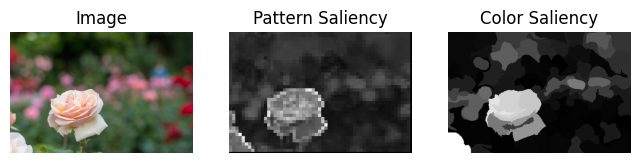

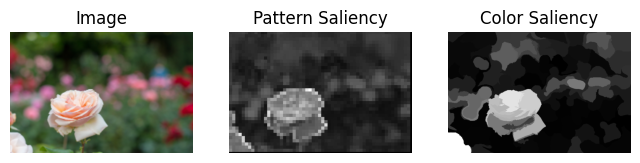

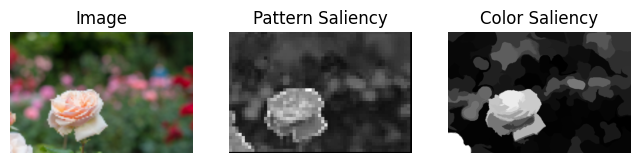

Final Output


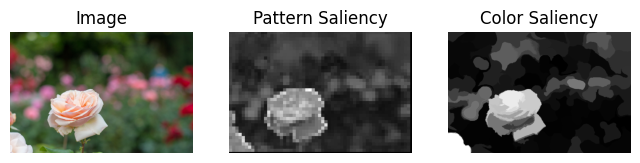

Gaussian Smoothed Output


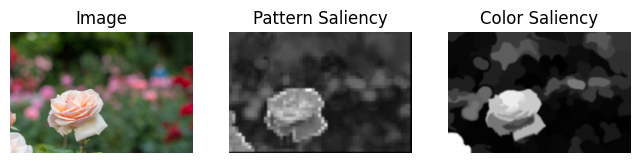

Combined Saliency


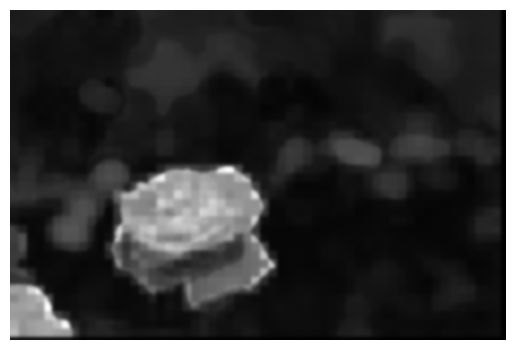

In [165]:
def ImgSaliency(img, scales, patchSizes):
  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  finalPatternSaliency = np.zeros((imgHeight, imgWidth))
  finalColorSaliency = np.zeros((imgHeight, imgWidth))

  patchSize = 9
  varThresh = 0.25

  avgTopSegmentsPos = np.array([0, 0])

  for scale in scales:
    scaled_img = cv2.resize(img, (int(imgWidth * scale), int(imgHeight * scale)))
    scaled_img = cv2.resize(scaled_img, (imgWidth, imgHeight))

    (patternSaliency, colorSaliency, avgTopSegmentPos) = Saliency(scaled_img, patchSize, varThresh, scale)

    patternSaliency = cv2.resize(patternSaliency, (imgWidth, imgHeight))
    colorSaliency = cv2.resize(colorSaliency, (imgWidth, imgHeight))

    finalPatternSaliency = finalPatternSaliency + patternSaliency
    finalColorSaliency = finalColorSaliency + colorSaliency

    plotSaliency(scaled_img, finalPatternSaliency, finalColorSaliency)

    avgTopSegmentsPos = avgTopSegmentsPos + avgTopSegmentPos

  finalPatternSaliency = finalPatternSaliency / len(scales)
  finalColorSaliency = finalColorSaliency / len(scales)
  avgTopSegmentsPos = avgTopSegmentsPos / len(scales)

  return finalPatternSaliency, finalColorSaliency, avgTopSegmentsPos

scales = [1, 0.5, 0.25]
patchSizes = [9, 5, 3]

(patternSaliency, colorSaliency, avgTopSegmentsPos) = ImgSaliency(img, scales, patchSizes)
print("Final Output")
plotSaliency(img, patternSaliency, colorSaliency)

gaussianSize = 9
gaussPatternSaliency = cv2.GaussianBlur(patternSaliency, (gaussianSize, gaussianSize), 0)
gaussColorSaliency = cv2.GaussianBlur(colorSaliency, (gaussianSize, gaussianSize), 0)
print("Gaussian Smoothed Output")
plotSaliency(img, gaussPatternSaliency, gaussColorSaliency)

combinedSaliency = gaussPatternSaliency * gaussColorSaliency
# combinedSaliency = cv2.GaussianBlur(combinedSaliency, (gaussianSize, gaussianSize), 0)
print("Combined Saliency")
plt.imshow(combinedSaliency, cmap = 'gray')
plt.axis('off')
plt.show()

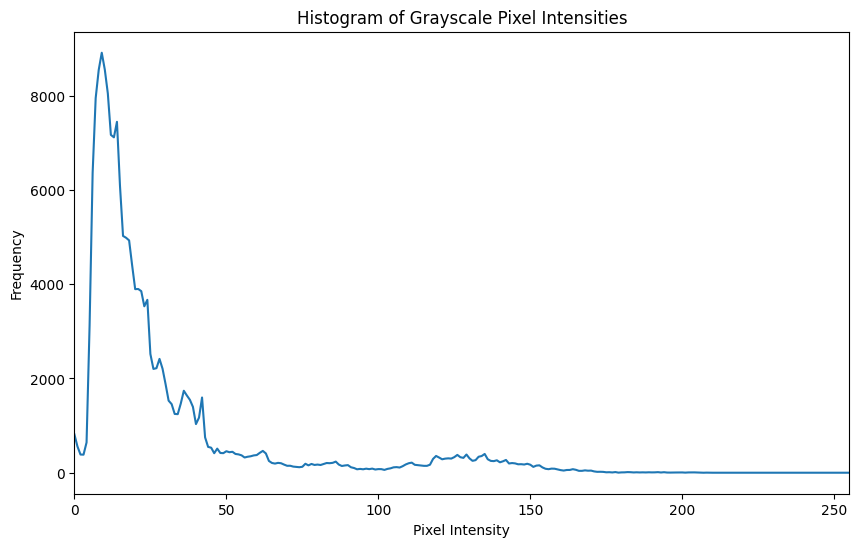

In [166]:
salient_img = np.uint8(combinedSaliency * 255)
histogram = cv2.calcHist([salient_img], [0], None, [256], [0, 256])

plt.figure(figsize=(10, 6))
plt.plot(histogram)
plt.title('Histogram of Grayscale Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xlim([0, 255])
plt.show()

In [167]:
retVignette, otsu_thresh_vignette = cv2.threshold(salient_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
avgTopSegmentsPos = np.array([0, 0])

imgHeight = combinedSaliency.shape[0]
imgWidth = combinedSaliency.shape[1]
count = 0

for i in range(imgHeight):
  for j in range(imgWidth):
    if(salient_img[i][j]  > 120):
      count = count + 1
      avgTopSegmentsPos = avgTopSegmentsPos + np.array([i, j])

avgTopSegmentsPos = np.uint8(avgTopSegmentsPos / count)
print(avgTopSegmentsPos)

[232 153]


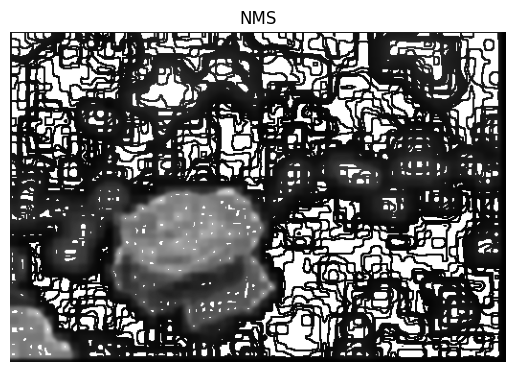

In [168]:
def NonMaximalSuppression(img, windowSize = 5):
  offset = windowSize // 2
  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  nms_img = np.copy(img)

  for x in range(offset, imgHeight - offset + 1):
    for y in range(offset, imgWidth - offset + 1):
      window = img[x - offset : x + offset + 1, y - offset : y + offset + 1]
      maxVal = window.max()
      if(img[x][y] == maxVal):
        nms_img[x][y] = 255

  return nms_img

nms_img = NonMaximalSuppression(salient_img, 5)
plt.imshow(nms_img, cmap='gray')
plt.title('NMS')
plt.axis('off')
plt.show()

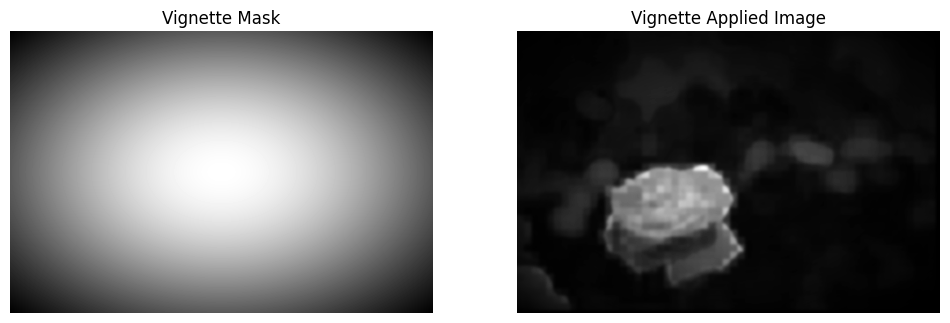

In [169]:
def create_vignette_mask(image, scale, pos):
  # print(pos)
  rows = img.shape[0]
  cols = img.shape[1]

  rowOffset = int(pos[0] - (rows // 2))
  colOffset = int(pos[1] - (cols // 2))

  x = np.linspace(0, cols - 1, cols)
  y = np.linspace(0, rows - 1, rows)
  x, y = np.meshgrid(x, y)

  x = (2 * x - (cols - 1)) / (cols - 1)
  y = (2 * y - (rows - 1)) / (rows - 1)

  r = np.sqrt(x**2 + y**2)

  sigma = scale
  vignette = np.exp(-(r**2) / (2 * sigma**2))

  vignette = (vignette - np.min(vignette)) / (np.max(vignette) - np.min(vignette))

  if len(image.shape) == 3:
      vignette = np.stack([vignette] * 3, axis = -1)

  vignetteShifted = np.copy(vignette)

  for row in range(rows):
    for col in range(cols):
      if(row + rowOffset >= 0 and row + rowOffset < rows and col + colOffset >= 0 and col + colOffset < cols):
        vignetteShifted[row][col] = vignette[row + rowOffset][col + colOffset]
      else:
        vignetteShifted[row][col] = 0

  # return vignetteShifted
  return vignette

vignette_mask = create_vignette_mask(salient_img, 0.9, avgTopSegmentsPos)
vignette_img = np.uint8(salient_img * vignette_mask)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(vignette_mask, cmap='gray')
plt.title('Vignette Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(vignette_img, cmap='gray')
plt.title('Vignette Applied Image')
plt.axis('off')



plt.show()

## Otsu Thresholding

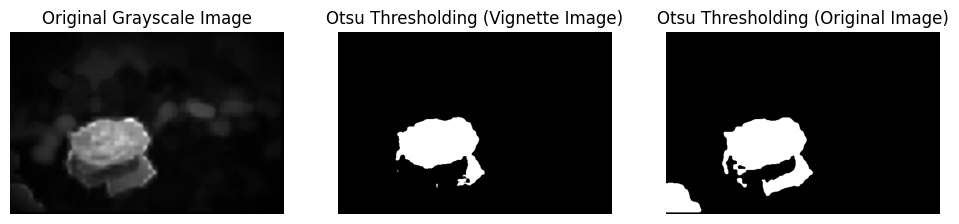

In [170]:
ret, otsu_thresh = cv2.threshold(vignette_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret_org, otsu_thresh_org = cv2.threshold(salient_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(vignette_img, cmap = 'gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(otsu_thresh, cmap = 'gray')
plt.title('Otsu Thresholding (Vignette Image)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(otsu_thresh_org, cmap = 'gray')
plt.title('Otsu Thresholding (Original Image)')
plt.axis('off')

plt.show()

# Hole Filling

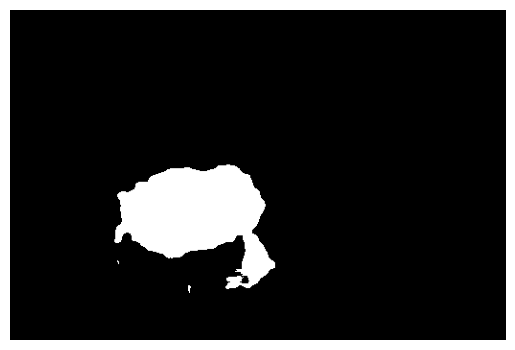

In [171]:
def HoleFilling(img):
  val, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
  filled_img = np.copy(binary_img)

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]
  mask = np.zeros((imgHeight+2, imgWidth+2), np.uint8)

  cv2.floodFill(filled_img, mask, (0,0), 255)
  filled_img_inv = cv2.bitwise_not(filled_img)
  hole_filled_img = binary_img | filled_img_inv

  return hole_filled_img

hole_filled_img = HoleFilling(otsu_thresh)
plt.imshow(hole_filled_img, cmap = 'gray')
plt.axis('off')
plt.show()

# Bounding Box

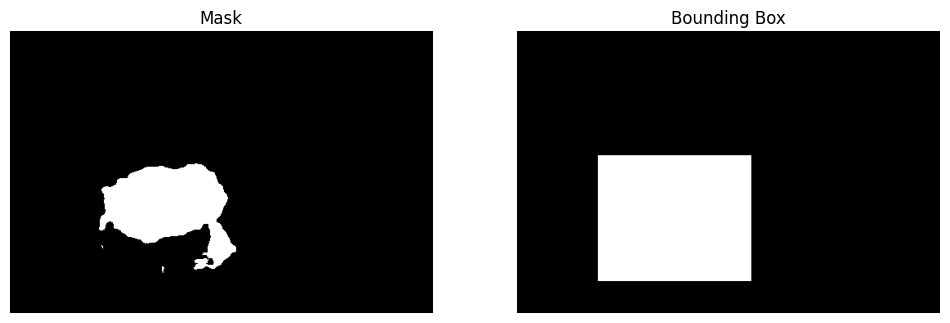

In [172]:
def BoundingBox(img):
  upperBound = -1
  lowerBound = -1
  leftBound = -1
  rightBound = -1

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  box_img = np.zeros((imgHeight, imgWidth))

  val = 0
  for x in range(imgHeight):
    for y in range(imgWidth):
      if(img[x][y] == 255):
        upperBound = x
        val = 1
        break
    if(val == 1):
      break

  val = 0
  for x in range(imgHeight - 1, -1, -1):
    for y in range(imgWidth):
      if(img[x][y] == 255):
        lowerBound = x
        val = 1
        break
    if(val == 1):
      break

  val = 0
  for y in range(imgWidth):
    for x in range(imgHeight):
      if(img[x][y] == 255):
        leftBound = y
        val = 1
        break
    if(val == 1):
      break

  val = 0
  for y in range(imgWidth - 1, -1, -1):
    for x in range(imgHeight):
      if(img[x][y] == 255):
        rightBound = y
        val = 1
        break
    if(val == 1):
      break

  # print(f"{upperBound}, {lowerBound}, {leftBound}, {rightBound}")

  padding = 10
  for x in range(imgHeight):
    for y in range(imgWidth):
      if(x >= min(upperBound, upperBound - padding) and x <= max(lowerBound, lowerBound + padding) and y >= min(leftBound, leftBound - padding) and y <= max(rightBound, rightBound + padding)):
        box_img[x][y] = 255

  return np.uint8(box_img)

box_img = BoundingBox(hole_filled_img)
box_filepath = "/content/boundingbox.jpg"
cv2.imwrite(box_filepath, box_img)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(hole_filled_img, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(box_img, cmap='gray')
plt.title('Bounding Box')
plt.axis('off')

plt.show()

## GrabCut

In [173]:
!pip install igraph

In [174]:
import numpy as np
import cv2
from collections import namedtuple
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import igraph as ig

In [175]:
def FitGMMs(img, alphas, n_components):

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]
  imgChannels = img.shape[2]

  fg = GaussianMixture(n_components=n_components)
  fgPixels = img[alphas == 1]
  fg.fit(fgPixels)

  bg = GaussianMixture(n_components=n_components)
  bgPixels = img[alphas == 0]
  bg.fit(bgPixels)

  return fg, bg

In [176]:
def GraphCut(img, alphas, fgGMM, bgGMM, beta, gamma, lamda, connectDiag):

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]
  imgChannels = img.shape[2]

  numPixels = imgHeight * imgWidth

  fgData = - fgGMM.score_samples(img.reshape((-1, imgChannels))).reshape((imgHeight, imgWidth))
  bgData = - bgGMM.score_samples(img.reshape((-1, imgChannels))).reshape((imgHeight, imgWidth))

  def ComputeV(i, j, oi, oj):
      diff = img[i, j] - img[oi, oj]
      V = gamma * np.exp(- beta * np.dot(diff, diff))
      return V

  def vid(i, j): # vertex ID
      return (imgWidth * i) + j

  def ind(idx): # image index
      return ((idx // imgWidth), (idx % imgWidth))

  graph = ig.Graph(directed = False)
  graph.add_vertices(numPixels + 2)
  S = numPixels
  T = numPixels + 1

  edges = []
  weights = []
  for i in range(imgHeight):
    for j in range(imgWidth):

      edges.append((vid(i, j), S))
      weights.append(bgData[i, j])

      edges.append((vid(i, j), T))
      weights.append(fgData[i, j])

      # Adding edges to neighbours
      if i > 0:
        edges.append((vid(i, j), vid(i-1, j)))
        weights.append(ComputeV(i, j, i-1, j))

      if j > 0:
        edges.append((vid(i, j), vid(i, j-1)))
        weights.append(ComputeV(i, j, i, j-1))

      if connectDiag:
        if i > 0 and j > 0:
          edges.append((vid(i, j), vid(i-1, j-1)))
          weights.append(ComputeV(i, j, i-1, j-1))

        if i > 0 and j < imgWidth - 1:
          edges.append((vid(i, j), vid(i-1, j+1)))
          weights.append(ComputeV(i, j, i-1, j+1))

  graph.add_edges(edges, attributes = {'weight': weights})
  cut = graph.st_mincut(S, T, capacity = 'weight')

  # print(S)
  # print(T)

  bgVertices = cut.partition[0]
  fgVertices = cut.partition[1]

  # print("background : ", np.array(bgVertices))
  # print("foreground : ", np.array(fgVertices))

  if S in bgVertices:
    bgVertices, fgVertices = fgVertices, bgVertices

  alphasNew = np.uint8(np.zeros((imgHeight, imgWidth)))
  for v in fgVertices:
    if v not in (S, T):
      alphasNew[ind(v)] = 1

  return cut.value, alphasNew

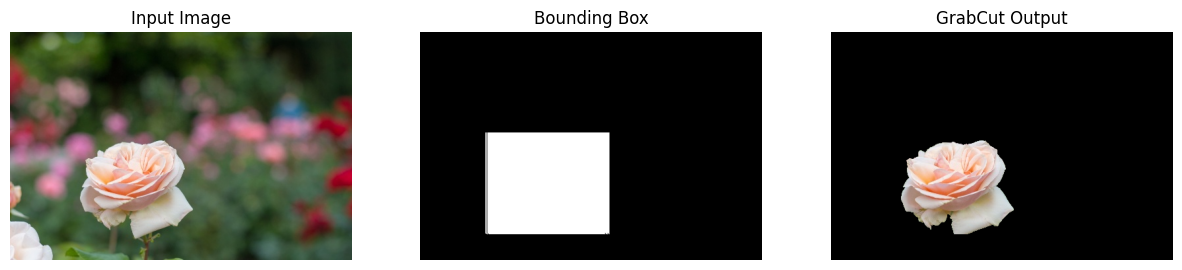

True

In [177]:
def GrabCut(img, mask, numComponents, gamma, lamda, numIterations, stopEarlyThresh, connectDiag):

  img = np.copy(img).astype(np.float32)
  alphas = mask.copy()

  imgHeight = img.shape[0]
  imgWidth = img.shape[1]

  # Calculate beta
  beta = 0
  for i in range(imgHeight):
    for j in range(imgWidth):
      if i > 0:
        diff = img[i, j] - img[i-1, j]
        beta = beta + diff.dot(diff)

      if j > 0:
        diff = img[i, j] - img[i, j-1]
        beta = beta + diff.dot(diff)

      if connectDiag:
        if i > 0 and j > 0:
          diff = img[i, j] - img[i-1, j-1]
          beta = beta + diff.dot(diff)

        if i > 0 and j < imgWidth - 1:
          diff = img[i, j] - img[i-1, j+1]
          beta = beta + diff.dot(diff)

  if connectDiag:
    beta = beta / (4 * imgHeight * imgWidth - 3 * imgHeight - 3 * imgWidth + 2)
  else:
    beta = beta / (2 * imgHeight * imgWidth - imgHeight - imgWidth)

  beta = 1 / (2 * beta)

  prevFlow = -1
  for i in range(numIterations):
    fgGMM, bgGMM = FitGMMs(img, alphas, numComponents)
    flow, alphas = GraphCut(img, alphas, fgGMM, bgGMM, beta, gamma, lamda, connectDiag)

    if prevFlow != -1 and abs(prevFlow - flow) < stopEarlyThresh:
      break

    prevFlow = flow

  return alphas

def PlotOutput(img, mask, output):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.title('Input Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(mask, cmap='gray')
  plt.title('Bounding Box')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(output)
  plt.title('GrabCut Output')
  plt.axis('off')

  plt.show()

input_img_filepath = "/content/img.jpg"
img = cv2.imread(input_img_filepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

boundingbox_img_filepath = "/content/boundingbox.jpg"
boundingbox = cv2.imread(boundingbox_img_filepath)
boundingbox = cv2.cvtColor(boundingbox, cv2.COLOR_BGR2GRAY)
boundingbox = np.uint8(img_as_float(boundingbox))

imgHeight = img.shape[0]
imgWidth = img.shape[1]

grabcut_img = np.copy(img)

numCompsGMM = 3
gamma = 50
lammbda = 9 * gamma
numIterations = 3
stopEarlyThresh = 1e-3

grabCutOutput = GrabCut(img, boundingbox, numCompsGMM, gamma, lammbda, numIterations, stopEarlyThresh, True)
mask_filepath = "/content/mask.jpg"
cv2.imwrite(mask_filepath, np.uint8(grabCutOutput * 255))

for x in range(imgHeight):
  for y in range(imgWidth):
    if(grabCutOutput[x][y] == 0 or boundingbox[x][y] == 0):
      grabcut_img[x][y] = np.array([0, 0, 0])

PlotOutput(img, boundingbox, grabcut_img)

output_filepath = "/content/output.jpg"
cv2.imwrite(output_filepath, cv2.cvtColor(grabcut_img, cv2.COLOR_RGB2BGR))